<img src="static/img/rosslog.png" align="left">  

# Rossmann Stores Predictions

This notebook covers basics of data cleaning, EDA, feature engineering, and data modelling. For more in-deph data analysis, please consider Kaggle Kernels: https://www.kaggle.com/c/rossmann-store-sales/kernels

**IMPORTANT: Make sure you do not skip any cells. In that case you risk not being able to accomplish given tasks.** 


## Rossmann Data Cleaning 

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. In this first part of the notebook we will walk you through basic steps that need to be done before start with baseline modelling.

### Load libraries and data

In [4]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
from pandas import DataFrame
from pandas import TimeGrouper

# Matplotlib for visualization
from matplotlib import pyplot as plt

# Display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns

In [5]:
# Load data from CSV
train_dataset = pd.read_csv("static/data/train.csv")
stores = pd.read_csv("static/data/store.csv")

train_dataset.head()

c:\users\nana_oa\appdata\local\programs\python\python36-32\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


The train data set contains sales by day for each store with the following columns:

- Store - a unique id number
- DayOfWeek/Date - the day of the week (1-7) and date (YYYY-MM-DD) for a sales data point
- Sales - the sales for a given day
- Customers - the number of customers on a given day. This column is highly correlated with sales and is not present in the test set.
- Open - Values: 0 = closed, 1 = open
- Promo - indicates whether a store was running a sales promotion that day
- StateHoliday - Values: a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if a store was affected by the closure of public schools on that day

###### Question 1

In [6]:
# YOUR CODE GOES HERE
# Print first five rows of the "stores" dataset

stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


The stores data set contains additional columns about each store that does not vary by day:

- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes the level of products available: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor
- CompetitionOpenSince[Month/Year] - month/year when the nearest competitor was opened
- Promo2 - indicator for a recurring promotion: 0 = store not participating, 1 = participating
- Promo2Since[Week/Year] - calendar week/year when the store started participating in Promo2
- PromoInterval - describes the intervals when Promo2 is started. E.g. "Feb,May,Aug,Nov" means each round starts in those months of any given year for that store

###### Question 2

In [7]:
# YOUR CODE GOES HERE
# Chech out the shape of the datasets. 
# We have a lot of data observations to play around.

t_shape = train_dataset.shape
st_shape = stores.shape
print('train shape:',  t_shape)
print('store shape: ',st_shape)



train shape: (1017209, 9)
store shape:  (1115, 10)


Take a look and understand different data types.

In [8]:
# Column datatypes
print(train_dataset.dtypes,'\n')
print(stores.dtypes)

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object 

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object


### Drop unwanted data

The overall goals during the data cleaning phase is to fix any problems with the provided data sets, such as:

- Fix inconsistent data
- Impute missing data (There are many ways to impute data, but for the purpose of this assignment, we will simply drop missing data for convenience)
- Convert categorical variables to one-hot encoded binary variables
- Check for outlying values, and correct them if necessary

We needed to fix these types of problems so that our prediction models could be fit as accurately as possible.

In [9]:
# Check for duplicates
train_dataset = train_dataset.drop_duplicates()
stores = stores.drop_duplicates()

# Print shape after removing duplicates
train_dataset.shape, stores.shape

((1017209, 9), (1115, 10))

There were no duplicates. Now, let us check closed stores, stores with no customers, and stores where sales values equals zero.

In [10]:
# Check how many records are for days when stores are closed
print("The number of records for closed stores: ", train_dataset[train_dataset.Open == 0].shape)

The number of records for closed stores:  (172817, 9)


Even though there are substantial number of records recorded when stores are closed, we are going to drop these observations because sales, our response variable, would be 0 for the days when the store is closed (there is no need for regression). 

In [11]:
# Drop observations with closed stores
train_dataset = train_dataset[train_dataset.Open != 0]
train_dataset.shape

(844392, 9)

###### Question 3

In [12]:
# YOUR CODE GOES HERE
# Print the number of stores where Customers=0

train_dataset[train_dataset.Customers == 0]



,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
86825,971,5,2015-05-15,0,0,1,0,0,1
142278,674,4,2015-03-26,0,0,1,0,0,0
196938,699,4,2015-02-05,0,0,1,1,0,0
322053,708,3,2014-10-01,0,0,1,1,0,0
330176,357,1,2014-09-22,0,0,1,0,0,0
340348,227,4,2014-09-11,0,0,1,0,0,0
340860,835,4,2014-09-11,0,0,1,0,0,0
341795,835,3,2014-09-10,0,0,1,0,0,0
346232,548,5,2014-09-05,0,0,1,1,0,1
346734,28,4,2014-09-04,0,0,1,1,0,0


###### Question 4

In [13]:
# YOUR CODE GOES HERE
# Print the number of stores where Sales=0

train_dataset[train_dataset.Sales == 0]


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
86825,971,5,2015-05-15,0,0,1,0,0,1
142278,674,4,2015-03-26,0,0,1,0,0,0
196938,699,4,2015-02-05,0,0,1,1,0,0
322053,708,3,2014-10-01,0,0,1,1,0,0
330176,357,1,2014-09-22,0,0,1,0,0,0
340348,227,4,2014-09-11,0,0,1,0,0,0
340860,835,4,2014-09-11,0,0,1,0,0,0
341795,835,3,2014-09-10,0,0,1,0,0,0
346232,548,5,2014-09-05,0,0,1,1,0,1
346734,28,4,2014-09-04,0,0,1,1,0,0


Let us check for missing values in `train_dataset` and `stores`

In [14]:
print(train_dataset.isnull().sum(),'\n')
print(stores.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64 

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


Drop unuseful columns:
- in `train_dataset`: `Open` is unuseful because it is consisted of all 1's (we dropped the observations with Open = 0 earlier).
- in `stores`: `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear`, `Promo2SinceWeek`, `Promo2SinceYear`, `PromoInterval` because they have too many missing values.

In [15]:
train_dataset.drop(['Open'], axis=1, inplace=True)
stores.drop(['CompetitionOpenSinceMonth', 
             'CompetitionOpenSinceYear', 
             'Promo2SinceWeek',
             'Promo2SinceYear',
             'PromoInterval'], axis=1, inplace=True)

Drop the 3 rows of `stores` where `CompetitionDistance` is missing:

In [16]:
stores.dropna(inplace=True)
stores.shape

(1112, 5)

### Joining the "Train" and "Store" tables 

###### Question 5

In [17]:
# YOUR CODE
# inner join `stores_encode` and `train_dataset_encode` on `Store`, and save the resulting df as `df_combined`.

#.set_index('key')
df_combined = train_dataset.join(stores.set_index('Store'), on='Store')
df_combined.head()


,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,0.0
1,2,5,2015-07-31,6064,625,1,0,1,a,a,570.0,1.0
2,3,5,2015-07-31,8314,821,1,0,1,a,a,14130.0,1.0
3,4,5,2015-07-31,13995,1498,1,0,1,c,c,620.0,0.0
4,5,5,2015-07-31,4822,559,1,0,1,a,a,29910.0,0.0


In [18]:
df_combined.shape

(844392, 12)

Check that the combined df has no missing values and that it has the proper one-hot encoded values

In [19]:
df_combined.isnull().sum()

Store                     0
DayOfWeek                 0
Date                      0
Sales                     0
Customers                 0
Promo                     0
StateHoliday              0
SchoolHoliday             0
StoreType              2186
Assortment             2186
CompetitionDistance    2186
Promo2                 2186
dtype: int64

In [20]:
df_combined[df_combined.StoreType.isnull()].head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2
290,291,5,2015-07-31,10052,973,1,0,1,NaN,NaN,NaN,NaN
621,622,5,2015-07-31,6306,540,1,0,1,NaN,NaN,NaN,NaN
878,879,5,2015-07-31,6000,466,1,0,0,NaN,NaN,NaN,NaN
1405,291,4,2015-07-30,9030,883,1,0,1,NaN,NaN,NaN,NaN
1736,622,4,2015-07-30,5412,406,1,0,1,NaN,NaN,NaN,NaN


In [21]:
#verifying that the reason I 'NaN' in some of the columns is because these stores don exist in the stores dataframe
stores[stores.Store == 291]

,Store,StoreType,Assortment,CompetitionDistance,Promo2


In [22]:
#There are 2186 rows in where the Store# is not found in the 'stores' data set so I'm dropping those rows

df_combined.dropna(inplace=True)
df_combined.shape

(842206, 12)

### New Feature Engineering on df_combined
- Extract month from `Date`

In [23]:
df_combined['Month'] = pd.DatetimeIndex(df_combined['Date']).month.values

## EDA

To determine what type of models and predictors might work best for predicting sales, we studied which factors are causing the most variance in sales.

#### Variations based on Store Attributes

One of the biggest sources of variance in sales is based on the store number. In the graph below we show the average sales for the first ten stores in the data set. We can see that the average sales are quite different for each store and that there is no linear pattern. We do see stores with similar sales levels, suggesting the stores may fall into groups.

The scatterplot below that shows the average sales for all the stores. We can again see that some stores have similar levels of sales, so it's likely we can group stores together when making sales predictions, which is something for which tree models are well suited.

Each store number is effectively a category with its own particular sales level. When predicting future sales, we would like a single model that can make predictions for each store rather than having to fit a separate model for each store.

c:\users\nana_oa\appdata\local\programs\python\python36-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


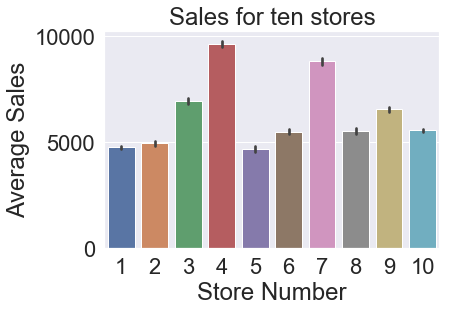

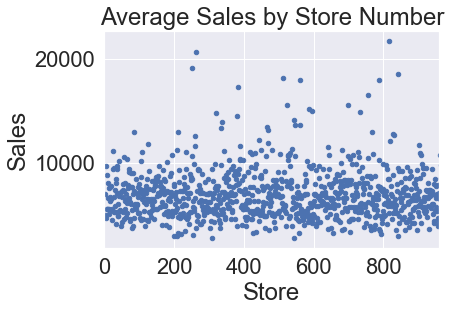

In [24]:
df_subset = df_combined[(df_combined['Store'] < 11)]
sns.set(font_scale=2)

# Plot store sales for stores 1 to 10
fig, ax = plt.subplots(1,1)

p3 = sns.barplot(x='Store', y='Sales', data=df_subset, ax=ax)
ax.set(xlabel='Store Number')
ax.set_ylabel('Average Sales')
ax.set_title('Sales for ten stores')

plt.show()

# Create a plot of average sales per store id
avg_sales_per_store = df_combined[['Sales', 'Store']].groupby('Store').mean()
avg_sales_per_store.reset_index().plot(kind='scatter', x='Store', y='Sales')
plt.xlim(0,960)
plt.title("Average Sales by Store Number")
plt.show()

In [25]:
#The data set has categorical variables for different store types and the assortment of products for sale at each store. We see that these categories are a source of variance in sales.

#### Impact of Number of Customers

After exploration of the train and test sets, we ascertained that only the training data contains the number of Customers feature. The visualization below shows the positive correlation between the number of customers and sales (and also outliers). This feature is highly correlated with sales, but it’s not available until after the sales occur (i.e. it’s not in the test set). But exploring this feature helps make a case for including a proxy for the Customers feature in our final predictors (see the Feature Engineering section).

We also see that there’s added information with the behavior of customers per StoreType. We see that StoreType d (shown in green) that projects to the upper left quadrant. This means that for the same level of Sales, StoreType d requires fewer customers than StoreType b (blue). There’s less clarity of StoreType impact in the middle of the cone shaped scatter, but we can certainly see the impact of Customers and Sales conditional on the StoreType mostly in the outer regions of the visualization. Thus StoreType is a relevant feature, but as a function of Customers, as we can see that around 2000 to 3000 Customers there’s a break in the cluster pattern of the middle section of the cone. Therefore, further substantiation for us to include a proxy of the Customers feature in the model.

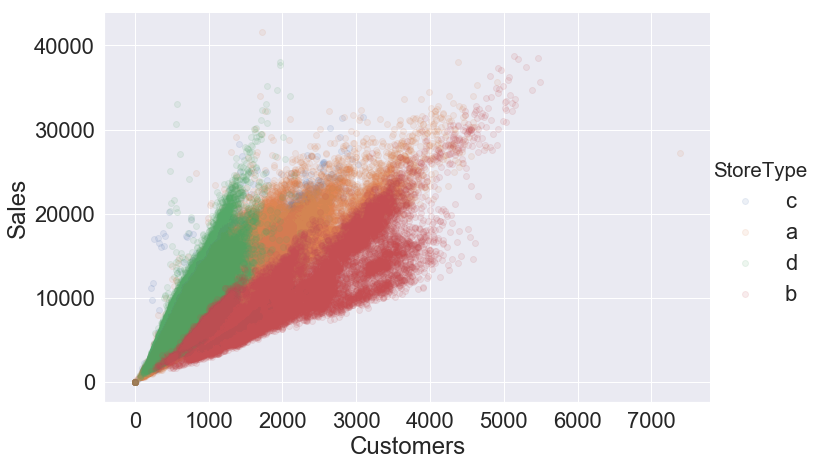

In [26]:
sns.lmplot(x='Customers', y='Sales', data=df_combined, hue='StoreType',fit_reg=False,
           scatter_kws={'alpha':0.1}, height=7, aspect=1.5)

c:\users\nana_oa\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


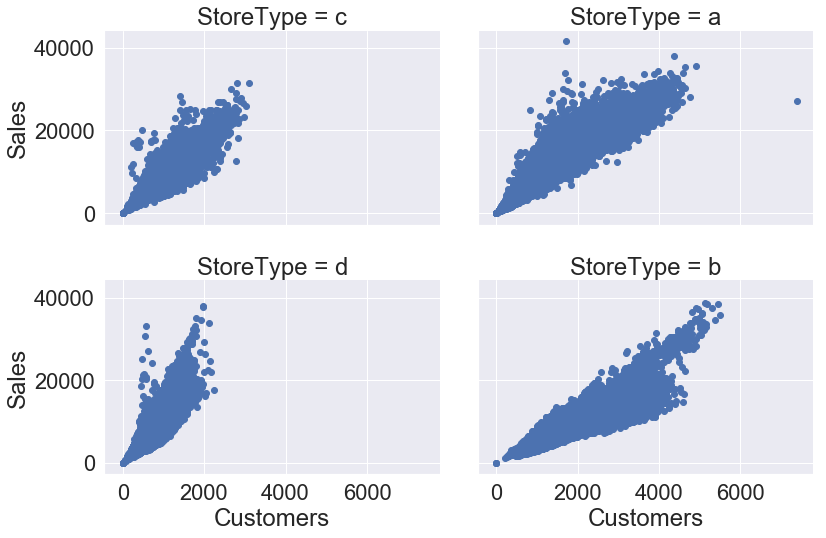

In [27]:
g = sns.FacetGrid(df_combined, col="StoreType", col_wrap=2, size=4, aspect=1.5)
g.map(plt.scatter, "Customers", "Sales")

### Process categorical columns

Before we can start modeling, we need to convert categorical variables into one-hot encoded binary variables.
In `df_combined`, one-hot encode the following:

- `Store`
- `StoreType`
- `Assortment` 
- `StateHoliday` 

Notice that we have two zero values for `StateHoliday`: one integer and one string. Let us fix this and have one string zero value for all `StateHoliday` representations.

In [28]:
# Display unique values of 'StateHoliday'
df_combined.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [29]:
df_combined.dtypes

Store                    int64
DayOfWeek                int64
Date                    object
Sales                    int64
Customers                int64
Promo                    int64
StateHoliday            object
SchoolHoliday            int64
StoreType               object
Assortment              object
CompetitionDistance    float64
Promo2                 float64
Month                    int64
dtype: object

In [30]:
df_test = pd.DataFrame({'A': [1, 0, 2, 3, 4], 'B': [5, 6, 0, 8, 9], 'C': ['a', 'b', 'c', 'd', 'e']})
#print(df_test['A'].replace(0, 5))
print(df_test)
df_test = df_test.replace({'A': 0, 'B': 5}, 'a')
#print(df_test)
df_test

   A  B  C
0  1  5  a
1  0  6  b
2  2  0  c
3  3  8  d
4  4  9  e


,A,B,C
0,1,a,a
1,a,6,b
2,2,0,c
3,3,8,d
4,4,9,e


In [31]:
#df_combined[df_combined.StateHoliday == '0']['StateHoliday'].head()
df_combined_test = df_combined.replace({'StateHoliday': 0}, '0')
df_combined_test.StateHoliday.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

###### Question 6

In [32]:
# YOUR CODE
# Your result shoud look like this: 
### array(['0', 'a', 'b', 'c'], dtype=object)
df_combined = df_combined.replace({'StateHoliday': 0}, '0')
df_combined.StateHoliday.unique()



array(['0', 'a', 'b', 'c'], dtype=object)

In [33]:
#testing to make sure not int 0's exist
df_combined[df_combined.StateHoliday == 0]['StateHoliday'].head()

Series([], Name: StateHoliday, dtype: object)

In [34]:
df_combined.Store.unique()

array([   1,    2,    3, ..., 1115,  876,  292], dtype=int64)

###### Question 7

In [35]:
#The next 5 lines of commented-out code were my attempts to get the dataframe size down to fix the memory error
#I was getting from one-hot encoding the 'Store' feature

#df_combined.head()

In [36]:
#df_combined['Store'] = df_combined['Store'].astype('uint16')

In [37]:
#df_combined.dtypes

In [38]:
#df_combined.head()

In [39]:
#df_combined.Store.unique()

In [40]:
# YOUR CODE
# Transforme the variables into one-hot-encoding using the get_dummies() method
df_combined = pd.get_dummies(df_combined, columns=['StoreType', 'Assortment', 'StateHoliday'])

In [41]:
#Test code for using the get_dummies functions
##df_test_dm = pd.DataFrame({'A': ['a', 'b', 'a'], 'B': ['b', 'a', 'c'], 'C': [1, 2, 3]})
##print(df_test_dm)
##df_test_dm = pd.get_dummies(df_test_dm, columns=['A', 'B'], sparse=True)
##print(df_test_dm)

## Rossmann Data Modeling

Due to the regressive predictive nature of The Rossmann Project, we decided to approach our model methodology with a Linear Regression base model with feature selection. Note: you can also consider Ridge regression to evaluate the effects of regularization on the predictive performance. 

*Note: The time dimension has a tremendous impact in this project. The Kaggle competition consisted in predicted the next 6 weeks (or 42 days), our splitting lead to have a testing set very large of over 900 days, explaining the fast degradation of the explained variance. These issues are the same the world of finance and economics are facing. For example the usage of an AR(n) to predict future outcomes quickly converge to a stationary states. In a real world, one would adjust the model based on the observed error. This is the spirit of tools such as the 'Kalman Filter' that are usually implemented in these domains.* 

*One other potential approach would consist in implementing more complicated model that naturally combine time series and decision tree, such as ART (Autoregressive Trees). The proposed method are outside of the scope of this course and thus we will focus on some other tehniques here.*

### Linear Regression

Linear regression is an intuitive first baseline model.

#### Load libraries

In [42]:
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [43]:
df_combined.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo',
       'SchoolHoliday', 'CompetitionDistance', 'Promo2', 'Month',
       'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c', 'StateHoliday_0',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c'],
      dtype='object')

Keep features for modeling:

In [44]:
#I could not resolve my memory error for encoding the 'Store' feature, so I'm modifying the code not to include it
#store_feats = [c for c in df_combined if "Store_" in c] # columns related to one-hot encoded `Store`
store_type_feats = [c for c in df_combined if "StoreType_" in c] # columns related to one-hot encoded `StoreType_`
assortment_feats = [c for c in df_combined if "Assortment_" in c] # columns related to one-hot encoded `Assortment_`
state_holiday_feats = [c for c in df_combined if "StateHoliday_" in c] # columns related to one-hot encoded `StateHoliday_`
extra_feats = ['CompetitionDistance', 'Promo2', 'Promo',
            'DayOfWeek', 'Month', 
            'SchoolHoliday']
#features = store_feats + store_type_feats + assortment_feats + state_holiday_feats + extra_feats
features = ['Store'] + store_type_feats + assortment_feats + state_holiday_feats + extra_feats

target = 'Sales'
print(features)

['Store', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'CompetitionDistance', 'Promo2', 'Promo', 'DayOfWeek', 'Month', 'SchoolHoliday']


#### Linear Regression

This takes a bit of time because we have a lot of predictor columns.

In [45]:
# Split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(df_combined[features], df_combined[target], test_size=0.33)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# Explained variance score: 1 is perfect prediction
print('Train R2 score: %.2f' % r2_score(y_train, regr.predict(X_train)))
print('Test R2 score: %.2f' % r2_score(y_test, y_pred))

Train R2 score: 0.21
Test R2 score: 0.21


###### Question 8
Plot the residual plot

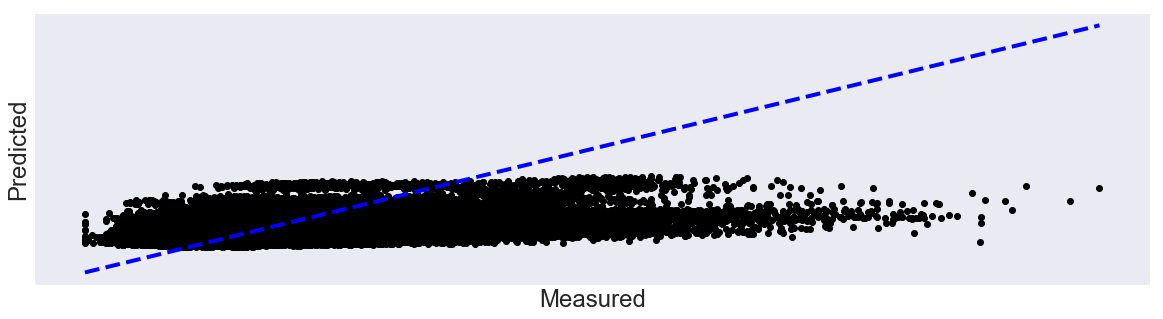

In [46]:
# YOUR CODE
# Plot residual plot: residuals vs. fitted values
# Residuals = y_true - y_pred
# Fitted values = y_pred
# Don't forget to label your plot

# Plot outputs
plt.figure(figsize=(20, 5))
plt.scatter(y_test, y_pred, color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, color='blue')

plt.ylabel('Predicted')
plt.xlabel('Measured')

plt.xticks(())
plt.yticks(())

plt.show()

###### Question 9
Can you reason about the residual plot?

###### Your Answer: This clear is not a model and could benefit from the 'Store' feature being one-hot encoded. But for the markers near the regression line, this seems to be a decent model and it would interesting and beneficial to see what the similarities are amoungst those markers

### Tree Based Models

It has been well established that bagging and other resampling techniques can be used to reduce the variance in model predictions. As several replicates of the original data set are created using random selection with replacement, at every step, each derivative data set is then used to construct a new model and the models are gathered together into an ensemble. To make a prediction, all of the models in the ensemble are polled and their results are averaged in the case of regression, which is our specific approach.

As well, it has been well established that a powerful modeling algorithm that makes good use of bagging is Random Forests, which works by training numerous decision trees each based on a different resampling of the original training data. The random forest algorithm improves on bagging by training each tree on a random sample of the available features, to prevent each tree from choosing the same predictors.

In Random Forests the bias of the full model is equivalent to the bias of a single decision tree, which itself has high variance. By creating many of these trees, a forest, and then averaging them, the variance of the final model can be greatly reduced over that of a single tree. In practice the only limitation we encountered on the size of the forest is computing time, as an infinite number of trees could be trained without ever increasing bias and with a continual - if asymptotically declining - decrease in the variance.

It is for the aforementioned that we considered Random Forests as a Baseline Ensemble and its constituent, the Decision Tree Regressor as a baseline model as well.

### Decision Trees

Decision trees were implemented as to evaluate the base consituent of the Random Forest ensemble. As per our research on previous models, Random Forest is a very good performance candidate for a baseline ensemble model for Rossmann.

Decision Trees are also evaluated as a non-parametric baseline model, which enriches the comparative analysis of the Linear Regression Models.

For fitting the decision tree model, we do not need to create dummy variables for categorical columns, since trees are able to make use of the factorized category values we created during data cleaning.

### Random Forest

Next we considered Random Forest models. 

In [47]:
# Load libraries
from sklearn.ensemble import RandomForestRegressor

c:\users\nana_oa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [48]:
rf = RandomForestRegressor(random_state=10)
rf.fit(X_train, y_train)

print('R2 score on train: ', rf.score(X_train, y_train))
print('R2 score on test: ', rf.score(X_test, y_test))

R2 score on train:  0.922925089096269
R2 score on test:  0.8520891446714242


###### Question 10

Plot the residual plot

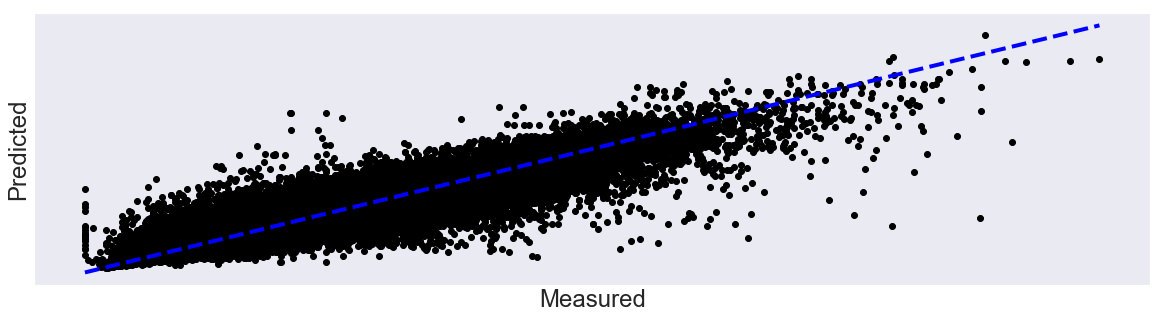

In [49]:
# YOUR CODE
# Plot residual plot: residuals vs. fitted values
# Residuals = y_true - y_pred
# Fitted values = y_pred
# Don't forget to label your plot

# Make predictions using the testing set for Randdom Forest
y_pred = rf.predict(X_test)


# Plot outputs
plt.figure(figsize=(20, 5))
plt.scatter(y_test, y_pred, color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, color='blue')

plt.ylabel('Predicted')
plt.xlabel('Measured')

plt.xticks(())
plt.yticks(())

plt.show()

###### Question 11
#### Which model is better? Give 1 possible approach to improve your best model. ** Your answer: The Random Forest Regression is better. It possibly can be improved by removing outliers and/or examine the coefficients of the features to see if there are any that features that have a low correlation and that are just adding noise**

## Export models 

In our final step, we will choose the best model and explore some important prediction elements. Our app accepts features and gives predictions based on users inputs. Let us see what kind of data input is neccessarry (this is important for you to setup the proper input on the Flask side). 

For example, take one simple observation (we are using first data row):

In [50]:
# Print first row
X_test.iloc[0]

Store                    453.0
StoreType_a                1.0
StoreType_b                0.0
StoreType_c                0.0
StoreType_d                0.0
Assortment_a               0.0
Assortment_b               0.0
Assortment_c               1.0
StateHoliday_0             1.0
StateHoliday_a             0.0
StateHoliday_b             0.0
StateHoliday_c             0.0
CompetitionDistance    75860.0
Promo2                     0.0
Promo                      0.0
DayOfWeek                  1.0
Month                     11.0
SchoolHoliday              0.0
Name: 650827, dtype: float64

Predict based on your first row:

In [51]:
# Test for your app
rf.predict(np.array(X_test.iloc[0]).reshape(1, -1))

array([6097.81])

Therefore, your input needs to be **numpy array** with the same column order as df_combined. Now, we can export pur model and get ready for the second part of the homework. 

In [52]:
from sklearn.externals import joblib
#joblib.dump(rf, 'rm.pkl', compress=True)

['rm.pkl']